# Project 6

This project uses data from the ‘w5000.csv’ dataset. Using Gurobi, you will solve a constrained mean-variance porfolio optimization problem, with long and short positions, and structural constraints. The solution will then be evaluated in an out-of-sample manner.

The first step is to extract, from the dataset, a vector of average returns and a covariance matrix of returns. To do this, you will have to select a subset of the assets, because some of the assets have data errors. Proceed as follows:

- a. If an asset is missing any data, exclude it.
- b. If, for an asset, the return for any given day exceeds 0.25 in absolute value, replace the return for that day with a moving average (of returns). If, for an asset, you need to perform this fix more than twenty Cmes,
exclude that asset.

Depending on how you apply these rules (precisely) you should be able to get at least 1800 assets that are legal.

- c. Construct the vector of average asset returns for this list of assets, as well as the covariance matrix of returns.

In [9]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
# Load the data
data = pd.read_csv('w5000.csv', usecols=lambda column: column != 'Unnamed: 0')

# a. If an asset is missing any data, exclude it.
data = data.dropna(axis=1)   # Drop columns with any missing data

# b. If, for an asset, the return for any given day exceeds 0.25 in absolute value, replace the return for that day with a moving average (of returns). 
# If, for an asset, you need to perform this fix more than twenty Cmes, exclude that asset.

# Calculate daily returns
returns = data.pct_change()

# Initialize a DataFrame to track the number of replacements per asset
replacements_count = pd.Series(0, index=returns.columns)

# Define the window for the moving average
moving_average_window = 5  # You can adjust this as needed

# Process each asset
for column in returns.columns:
    # Find indices where the absolute return exceeds 25%
    extreme_values_indices = returns[column].abs() > 0.25
    
    # Count the number of replacements needed
    replacements_count[column] = extreme_values_indices.sum()
    
    # Replace extreme returns with moving average of returns
    # Using a centered moving average; adjust parameters as needed
    moving_average = returns[column].rolling(window=moving_average_window, center=True).mean()
    returns[column] = returns[column].where(~extreme_values_indices, moving_average)

# Exclude assets that require more than 20 corrections
returns = returns.loc[:, replacements_count <= 20]

# c. Construct the vector of average asset returns for this list of assets, 
# as well as the covariance matrix of returns.

# Check the number of remaining assets
n = len(returns.columns)  # Assign the number of legal assets to 'n'
if n >= 1800:
    print(f"Number of legal assets: {n}")

    average_returns = returns.mean()     # Calculate average returns for each asset
    standard_deviations = returns.std()  # Calculate standard deviation for each asset
    covariance_matrix = returns.cov()    # Calculate covariance matrix

    print("\nAverage Returns:")
    print(average_returns)
    print("\nStandard Deviations:")
    print(standard_deviations)
    print("\nCovariance Matrix:")
    print(covariance_matrix)
else:
    print(f"Insufficient number of assets remaining ({n}). Adjust criteria or check data.")

Number of legal assets: 2035

Average Returns:
w5000         0.000323
A.Close       0.000566
AA.Close      0.000332
AAL.Close     0.000664
AAME.Close    0.000108
                ...   
ZION.Close    0.000050
ZIOP.Close    0.000443
ZIXI.Close    0.000591
ZN.Close     -0.000268
ZUMZ.Close    0.000703
Length: 2035, dtype: float64

Standard Deviations:
w5000         0.012747
A.Close       0.020153
AA.Close      0.029312
AAL.Close     0.042476
AAME.Close    0.042063
                ...   
ZION.Close    0.032639
ZIOP.Close    0.045586
ZIXI.Close    0.034223
ZN.Close      0.040358
ZUMZ.Close    0.035907
Length: 2035, dtype: float64

Covariance Matrix:
               w5000   A.Close  AA.Close  AAL.Close  AAME.Close  AAN.Close  \
w5000       0.000162  0.000195  0.000261   0.000273    0.000021   0.000113   
A.Close     0.000195  0.000406  0.000333   0.000324    0.000012   0.000144   
AA.Close    0.000261  0.000333  0.000859   0.000393    0.000037   0.000167   
AAL.Close   0.000273  0.000324  0.0

In [3]:
legal_assets = n
legal_assets

2035

#### We got 2035 stocks which is more than 1800 stocks


### Importing Libraries
- `pandas`: Used for data manipulation and analysis.
- `numpy`: Adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions.
- `gurobipy`: Python interface for Gurobi, which is an optimization solver.
- `matplotlib.pyplot`: Used for creating static, interactive, and animated visualizations in Python.

### Data Preprocessing
1. **Loading Data:**
   - `data = pd.read_csv('w5000.csv', usecols=lambda column: column != 'Unnamed: 0')`: Loads data from a CSV file, excluding any column named 'Unnamed: 0'. This is often used to ignore index columns that have no name when data is exported to CSV.

2. **Handling Missing Data:**
   - `data = data.dropna(axis=1)`: Removes any columns (axis=1) that contain missing values.

3. **Calculating Daily Returns:**
   - `returns = data.pct_change()`: Calculates the percentage change between the current and a prior element. This is commonly used to find the returns from prices of stocks or assets.

### Identifying and Handling Outliers
1. **Tracking Replacements:**
   - Initializes a `replacements_count` Series to keep track of how many times values are replaced in each asset column due to extreme values.

2. **Defining Moving Average Parameters:**
   - Specifies a window size for the moving average calculation. A window of 5 is used here, meaning that the average is taken over 5 days.

3. **Processing Each Asset for Extreme Values:**
   - Loops through each column in the returns DataFrame.
   - `extreme_values_indices = returns[column].abs() > 0.25`: Identifies the positions where the absolute return exceeds 25%.
   - The count of these extreme values is recorded.
   - `moving_average = returns[column].rolling(window=moving_average_window, center=True).mean()`: Calculates the centered moving average of returns.
   - Uses `.where()` to replace the extreme returns with the calculated moving average values.

### Excluding Volatile Assets
- Assets needing more than 20 replacements (due to extreme values) are excluded to ensure data quality and stability.
- `returns = returns.loc[:, replacements_count <= 20]`: Filters out columns that exceed the replacement threshold.

### Final Checks and Calculations
- If there are at least 1800 "legal" assets left after filtering:
  - Calculates the average returns, standard deviations, and the covariance matrix of the returns, which are essential metrics for portfolio optimization.
  - These values are printed out for review or further processing.

### Summary
The script is structured to prepare a dataset for portfolio optimization by cleaning the data, removing outliers, and calculating key financial statistics. This setup ensures that the dataset is robust and ready for subsequent optimization tasks, such as those that might be performed using the Gurobi optimizer (though the actual optimization step isn't included in this script).

## Portfolio Optimization

Now we describe the actual portfolio optimizaCon problem

- d. The objective is as usual: we minimize a risk term minus the porfolio return. The risk term (as is customary)
equals variance of portfolio return multiplied by a risk aversion factor. Your code should work with values
of this factor ranging from 0 to 1e6. The variables are of the form xj as discussed in class.
- e. Each variable xj can be long or short, i.e., nonnegative or nonpositive. You can accomplish this by writing xj as the difference of two other variables, 
i.e. = pj – mj, which are both nonnegative. But you will need to make sure that these two other variables cannot be simultaneously nonzero, and you will need a binary
variable to ensure that.
- f. Each variable satisfies | xj | <=u, where u is a number input to the program.
- g. Each variable xj is, either, zero, or it satisfies | xj | >= d where the number d is also input to the program.
- h. There is a constraint that the number of assets in the long side (with nonzero positions) is between two
numbers L and U, which are input when the program runs.
- i. The same applies to the short side (with two other numbers).
- j. There is a constraint saying that the sum of asset positions on the long side is between two numbers, p and
q.
- k. Similarly with the short side.

### Objective function

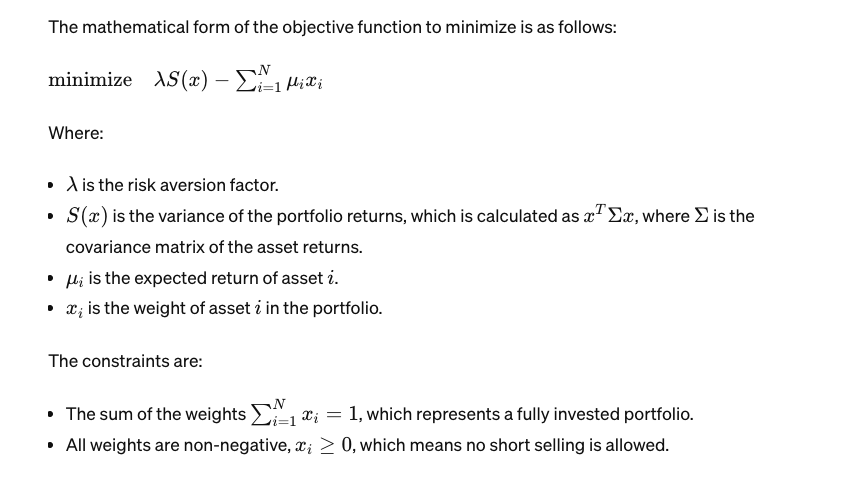

In [1]:
from IPython.display import Image
Image(filename='Objective.png')

### Constraints

e. Each variable xj can be long or short, i.e., nonnegative or nonpositive. You can accomplish this by writing xj as the difference of two other variables, i.e. = pj – mj, which are both nonnegative. But you will need to make sure that these two other variables cannot be simultaneously nonzero, and you will need a binary variable to ensure that.

Long (want the price to increase) = buy and hold for increase in price and sell the higher price

Short (want the price to decrease)= borrow and hope the price to decrease and sell it

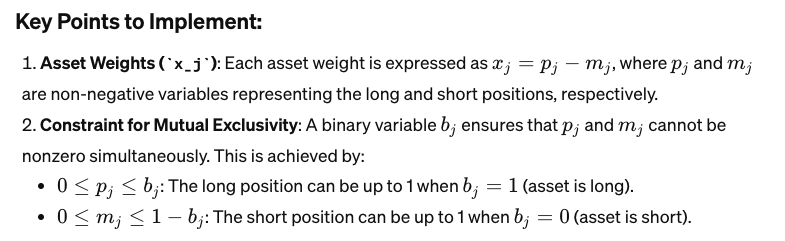

In [3]:
Image(filename='e.png')

f. Each variable satisfies | xj | <=u, where u is a number input to the program.

g. Each variable xj is, either, zero, or it satisfies | xj | >= d where the number d is also input to the program.

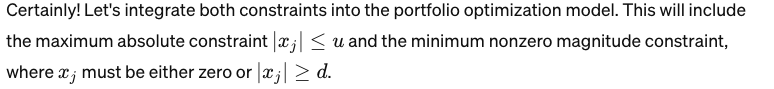

In [4]:
Image(filename='fg.png')

h. There is a constraint that the number of assets in the long side (with nonzero posiCons) is between two numbers L and U, which are input when the program runs.

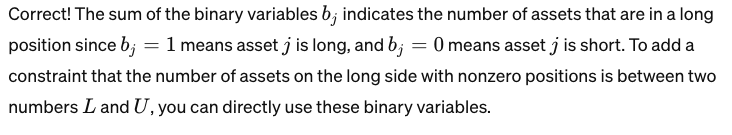

In [5]:
Image(filename='h.png')

i. The same applies to the short side (with two other numbers).

Note: in our code, we use L_short instead of Smin and U_short instead of Smax

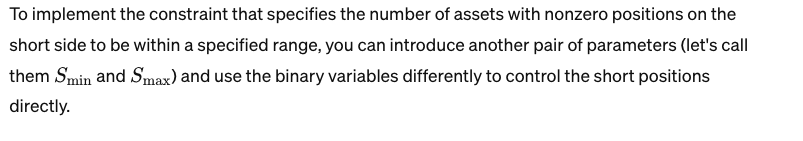

In [6]:
Image(filename='i.png')

j. There is a constraint saying that the sum of asset positions on the long side is between two numbers, 
p and q.

Note: in our code, we use p_value instead of p and q_value instead of q

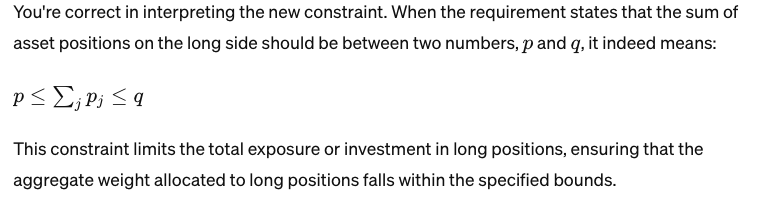

In [7]:
Image(filename='j.png')

k. Similarly with the short side.

Note: in our code, we use r_value instead of r and s_value instead of s

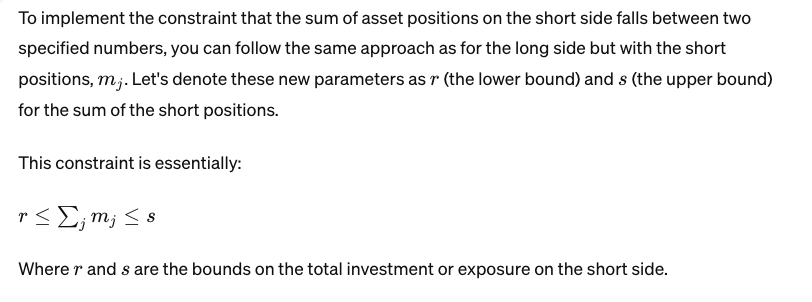

In [8]:
Image(filename='k.png')

### Note: 

#### There variables are percentage of portfolio in which their value can range from 0 (0%) to 1 (100%).
- x[i]
- p[i]
- m[i]

#### These parameters are percentage of portfolio in which their value can range from 0 (0%) to 1 (100%).
- u
- d
- p_value
- q_value
- r_value 
- s_value 

#### These parameters are number of assets in portfolio in which their value can range from 0 to n (total assets).
- L
- U
- L_short
- U_short

In [15]:
# Convert the average returns and covariance matrix to numpy arrays if they are pandas objects
average_returns_np = np.array(average_returns)
covariance_matrix_np = np.array(covariance_matrix)
print(average_returns_np)
print(covariance_matrix_np)

[ 0.00032285  0.0005662   0.00033178 ...  0.0005907  -0.00026824
  0.00070265]
[[1.62474915e-04 1.94688754e-04 2.61422749e-04 ... 1.80298753e-04
  7.90710170e-05 2.12423637e-04]
 [1.94688754e-04 4.06153371e-04 3.32515816e-04 ... 2.47704007e-04
  1.28104114e-04 2.44059716e-04]
 [2.61422749e-04 3.32515816e-04 8.59183915e-04 ... 2.97439033e-04
  1.43053623e-04 3.11921639e-04]
 ...
 [1.80298753e-04 2.47704007e-04 2.97439033e-04 ... 1.17122679e-03
  1.04089028e-04 2.36757534e-04]
 [7.90710170e-05 1.28104114e-04 1.43053623e-04 ... 1.04089028e-04
  1.62877762e-03 9.63129723e-05]
 [2.12423637e-04 2.44059716e-04 3.11921639e-04 ... 2.36757534e-04
  9.63129723e-05 1.28930355e-03]]


In [7]:
# Initialize the Gurobi model
model = gp.Model("portfolio_optimization")

# Asset variables: long positions (p), short positions (m), binary indicators for long/short (b), and net positions (x)
p = model.addVars(n, lb=0.0, ub=1.0, name="p")
m = model.addVars(n, lb=0.0, ub=1.0, name="m")
b = model.addVars(n, vtype=GRB.BINARY, name="b")
x = model.addVars(n, lb=-1.0, ub=1.0, name="x")  # Assuming positions can range from -100% to 100%

# Parameters for constraints

# f. Each variable satisfies | xj | <=u, where u is a number input to the program.
u = 1.0       # Maximum asset weight magnitude

# g. Each variable xj is, either, zero, or it satisfies | xj | >= d 
# where the number d is also input to the program.
d = 0.0001    # Minimum nonzero asset weight magnitude

# h. There is a constraint that the number of assets in the long side (with nonzero positions) 
# is between two numbers L and U, which are input when the program runs.
L = 0         # Minimum number of long assets
U = n         # Maximum number of long assets

# i. The same applies to the short side (with two other numbers).
L_short = 0   # Minimum number of short assets
U_short = n   # Maximum number of short assets

# j. There is a constraint saying that the sum of asset positions on the long side 
# is between two numbers, p and q.
p_value = 0   # Minimum sum of long positions
q_value = 1   # Maximum sum of long positions

# k. Similarly with the short side.
r_value = 0   # Minimum sum of short positions
s_value = 1   # Maximum sum of short positions

# Add constraints

# e. Each variable xj can be long or short, i.e., nonnegative or nonpositive. 
# You can accomplish this by writing xj as the difference of two other variables, 
# i.e. = pj – mj, which are both nonnegative. But you will need to make sure that 
# these two other variables cannot be simultaneously nonzero, 
# and you will need a binary variable to ensure that.

model.addConstrs(x[i] == p[i] - m[i] for i in range(n))

# f. Each variable satisfies | xj | <=u, where u is a number input to the program.
model.addConstrs(p[i] <= u * b[i] for i in range(n))
model.addConstrs(m[i] <= u * (1 - b[i]) for i in range(n))

# g. Each variable xj is, either, zero, or it satisfies | xj | >= d 
where the number d is also input to the program.
model.addConstrs((p[i] >= d * b[i]) for i in range(n))
model.addConstrs((m[i] >= d * (1 - b[i])) for i in range(n))

# h. There is a constraint that the number of assets in the long side (with nonzero positions) 
# is between two numbers L and U, which are input when the program runs.
model.addConstr(sum(b[i] for i in range(n)) >= L, "min_long_assets")
model.addConstr(sum(b[i] for i in range(n)) <= U, "max_long_assets")

# i. The same applies to the short side (with two other numbers).
model.addConstr(sum(1 - b[i] for i in range(n)) >= L_short, "min_short_assets")
model.addConstr(sum(1 - b[i] for i in range(n)) <= U_short, "max_short_assets")

# j. There is a constraint saying that the sum of asset positions on the long side 
# is between two numbers, p and q.
model.addConstr(sum(p[i] for i in range(n)) >= p_value, "min_sum_long_positions")
model.addConstr(sum(p[i] for i in range(n)) <= q_value, "max_sum_long_positions")

# k. Similarly with the short side.
model.addConstr(sum(m[i] for i in range(n)) >= r_value, "min_sum_short_positions")
model.addConstr(sum(m[i] for i in range(n)) <= s_value, "max_sum_short_positions")
model.addConstr(sum(x[i] for i in range(n)) == 1, "budget")

# Risk aversion factors range
risk_aversions = [0, 1, 10, 100, 1e3, 1e4, 1e5, 1e6]

# Prepare a dictionary to store results
portfolio_positions = {}

# d. The objective is as usual: we minimize a risk term minus the porfolio return. 
# The risk term (as is customary) equals variance of portfolio return multiplied by a risk aversion factor. 
# Your code should work with values of this factor ranging from 0 to 1e6. 
# The variables are of the form xj as discussed in class.


# Loop over risk aversion factors
for risk_aversion in risk_aversions:
    model.reset()
    portfolio_variance = gp.QuadExpr()
    expected_return = gp.LinExpr()
    for i in range(n):
        for j in range(n):
            portfolio_variance += covariance_matrix_np[i, j] * x[i] * x[j]
        expected_return += average_returns_np[i] * x[i]
    model.setObjective(risk_aversion * portfolio_variance - expected_return, GRB.MINIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # Store each asset's net position for the current risk aversion
        positions = {i: x[i].X for i in range(n)}
        portfolio_positions[risk_aversion] = positions
        print(f'Optimal Portfolio Weights for risk aversion {risk_aversion}:')
        for i in range(n):
            print(f'Asset {i}: Net Position {positions[i]}')
    else:
        print(f"Optimization was not successful for risk aversion {risk_aversion}.")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-11
Discarded solution information
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 22.6.0 22G313)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10184 rows, 8140 columns and 40700 nonzeros
Model fingerprint: 0xcf8ac9fa
Variable types: 6105 continuous, 2035 integer (2035 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [6e-07, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 10184 rows and 8140 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.03 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: -0.00173753 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.737531076485e-03, best bound -1.737531076485e-03, gap 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10184 rows, 8140 columns and 40700 nonzeros
Model fingerprint: 0x1441e7d3
Model has 2071630 quadratic objective terms
Variable types: 6105 continuous, 2035 integer (2035 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [6e-07, 3e-03]
  QObjective range [5e-08, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 10183 rows and 6105 columns
Presolve time: 0.20s
Presolved: 1 rows, 2035 columns, 2035 nonzeros
Presolved model has 2071630 quadratic objective terms
Variable types: 2035 continuous, 0 integer (0 binary)
Root relaxation presolve time: 0.40s
Root relaxation presolved: 1 rows, 2035 columns, 2035 nonzeros
Root relaxation presolved model has 2071630 quadratic objective terms
Root barrier log...

Ordering

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10184 rows, 8140 columns and 40700 nonzeros
Model fingerprint: 0xbef4c2f8
Model has 2071630 quadratic objective terms
Variable types: 6105 continuous, 2035 integer (2035 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [6e-07, 3e-03]
  QObjective range [5e-07, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 10183 rows and 6105 columns
Presolve time: 0.20s
Presolved: 1 rows, 2035 columns, 2035 nonzeros
Presolved model has 2071630 quadratic objective terms
Variable types: 2035 continuous, 0 integer (0 binary)
Root relaxation presolve time: 0.42s
Root relaxation presolved: 1 rows, 2035 columns, 2035 nonzeros
Root relaxation presolved model has 2071630 quadratic objective terms
Root barrier log...

Ordering

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10184 rows, 8140 columns and 40700 nonzeros
Model fingerprint: 0x7ac94850
Model has 2071630 quadratic objective terms
Variable types: 6105 continuous, 2035 integer (2035 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [6e-07, 3e-03]
  QObjective range [5e-06, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 10183 rows and 6105 columns
Presolve time: 0.20s
Presolved: 1 rows, 2035 columns, 2035 nonzeros
Presolved model has 2071630 quadratic objective terms
Variable types: 2035 continuous, 0 integer (0 binary)
Root relaxation presolve time: 0.45s
Root relaxation presolved: 1 rows, 2035 columns, 2035 nonzeros
Root relaxation presolved model has 2071630 quadratic objective terms
Root barrier log...

Ordering

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10184 rows, 8140 columns and 40700 nonzeros
Model fingerprint: 0xf3dd732a
Model has 2071630 quadratic objective terms
Variable types: 6105 continuous, 2035 integer (2035 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [6e-07, 3e-03]
  QObjective range [5e-05, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 10183 rows and 6105 columns
Presolve time: 0.20s
Presolved: 1 rows, 2035 columns, 2035 nonzeros
Presolved model has 2071630 quadratic objective terms
Variable types: 2035 continuous, 0 integer (0 binary)
Root relaxation presolve time: 0.41s
Root relaxation presolved: 1 rows, 2035 columns, 2035 nonzeros
Root relaxation presolved model has 2071630 quadratic objective terms
Root barrier log...

Ordering

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10184 rows, 8140 columns and 40700 nonzeros
Model fingerprint: 0xea4dee87
Model has 2071630 quadratic objective terms
Variable types: 6105 continuous, 2035 integer (2035 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [6e-07, 3e-03]
  QObjective range [5e-04, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 10183 rows and 6105 columns
Presolve time: 0.20s
Presolved: 1 rows, 2035 columns, 2035 nonzeros
Presolved model has 2071630 quadratic objective terms
Variable types: 2035 continuous, 0 integer (0 binary)
Root relaxation presolve time: 0.42s
Root relaxation presolved: 1 rows, 2035 columns, 2035 nonzeros
Root relaxation presolved model has 2071630 quadratic objective terms
Root barrier log...

Ordering

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10184 rows, 8140 columns and 40700 nonzeros
Model fingerprint: 0xe0965c16
Model has 2071630 quadratic objective terms
Variable types: 6105 continuous, 2035 integer (2035 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [6e-07, 3e-03]
  QObjective range [5e-03, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 10183 rows and 6105 columns
Presolve time: 0.20s
Presolved: 1 rows, 2035 columns, 2035 nonzeros
Presolved model has 2071630 quadratic objective terms
Variable types: 2035 continuous, 0 integer (0 binary)
Root relaxation presolve time: 0.40s
Root relaxation presolved: 1 rows, 2035 columns, 2035 nonzeros
Root relaxation presolved model has 2071630 quadratic objective terms
Root barrier log...

Ordering

### Import Libraries and Data Preprocessing
Before the provided code snippet, it's assumed that necessary libraries are imported, and data like returns and covariance are loaded and processed.

### Convert Data to Numpy Arrays
```python
average_returns_np = np.array(average_returns)
covariance_matrix_np = np.array(covariance_matrix)
```
This part converts `average_returns` and `covariance_matrix` from potentially pandas DataFrames or Series to numpy arrays, which are more efficient for numerical operations in loops and array manipulations during optimization.

### Initialize the Gurobi Model
```python
model = gp.Model("portfolio_optimization")
```
Initializes a new optimization model named "portfolio_optimization".

### Define Variables
Variables for asset positions are defined here:
- `p[i]`: Long position for asset `i`.
- `m[i]`: Short position for asset `i`.
- `b[i]`: Binary variable that decides if asset `i` is long (`1`) or not (`0`).
- `x[i]`: Net position for asset `i`, calculated as `p[i] - m[i]`, ranging from -100% to 100%.

### Set Parameters for Constraints
These are thresholds and limits used in constraints to define the model behavior:
- `u`: Upper limit on asset weights.
- `d`: Lower threshold for asset weights to be considered significantly non-zero.
- `L` and `U`: Minimum and maximum number of assets allowed in long positions.
- `L_short` and `U_short`: Minimum and maximum number of assets allowed in short positions.
- `p_value`, `q_value`, `r_value`, `s_value`: Bounds on the sum of long and short positions, respectively.

### Add Constraints to the Model
- Equality constraint for `x[i]` ensures the net position is the difference between long and short positions.
- Position bounds are enforced using `b[i]`, ensuring that positions respect the binary decision.
- Total long and short assets are bounded within specified limits.
- The budget constraint ensures the total net investment (sum of all `x[i]`) equals 100% (normalized to 1 in the model).

### Risk Aversion Loop
- Iterates over different levels of risk aversion to see how the optimal portfolio changes.
- Each iteration resets the model, recalculates the objective (a weighted sum of portfolio variance and expected return), and solves for the optimal asset positions.
- The objective is set to minimize `risk_aversion * portfolio_variance - expected_return`, balancing between minimizing variance (risk) and maximizing returns based on the risk_aversion factor.

### Store and Print Results
- The optimal positions for each asset at each level of risk aversion are stored and printed. If the optimization is successful, it prints the asset positions; otherwise, it notes an unsuccessful optimization.

This portfolio optimization setup is typical in finance where investors need to decide the best way to allocate capital across a range of assets to maximize returns for a given level of risk. The script effectively uses Gurobi's capabilities to model and solve this complex optimization problem.

## Simulation

Your program should work for all choices of the input parameters above.

- l. After solving the portfolio optimization problem, simulate, and plot, the evolution of the value of the
porfolio as asset prices change over 100 consecutive days. For a given asset, k, we adjust its price 
from each day, to the next by a random amount. Suppose that the average return for asset k is r(k), 
and its standard deviation is d(k). Then, on each day t (between 0 and 99) we draw a uniform random variable r, 
chosen from the interval [r(k) – d’(k), r(k) + d’(k)], where d’(k) = min( d(k), r(k)/2 ). 
Then we scale the price of asset k on day t by multiplying it times 1 + r, to obtain the price of 
asset k on day t+1. We do this for each asset independently, for t = 0, then t=1, and so on, 
until reaching t = 99. As the price of all the assets evolve, so will the value of the porfolio. 
Assume an initial value of 1e9 (one billion). Plot this evolution.

Professor's announcement on l.

You may see a number of assets (how many depends on which subfamily you work with) 
whose average return is negative.  

If so, in part l of Project 6 you should replace the definition of d'(k) by d'(k) = min{ d(k), | r(k)/2 |}.

Risk Aversion Factor: 0
Risk Aversion Factor: 1
Risk Aversion Factor: 10
Risk Aversion Factor: 100
Risk Aversion Factor: 1000.0
Risk Aversion Factor: 10000.0
Risk Aversion Factor: 100000.0
Risk Aversion Factor: 1000000.0


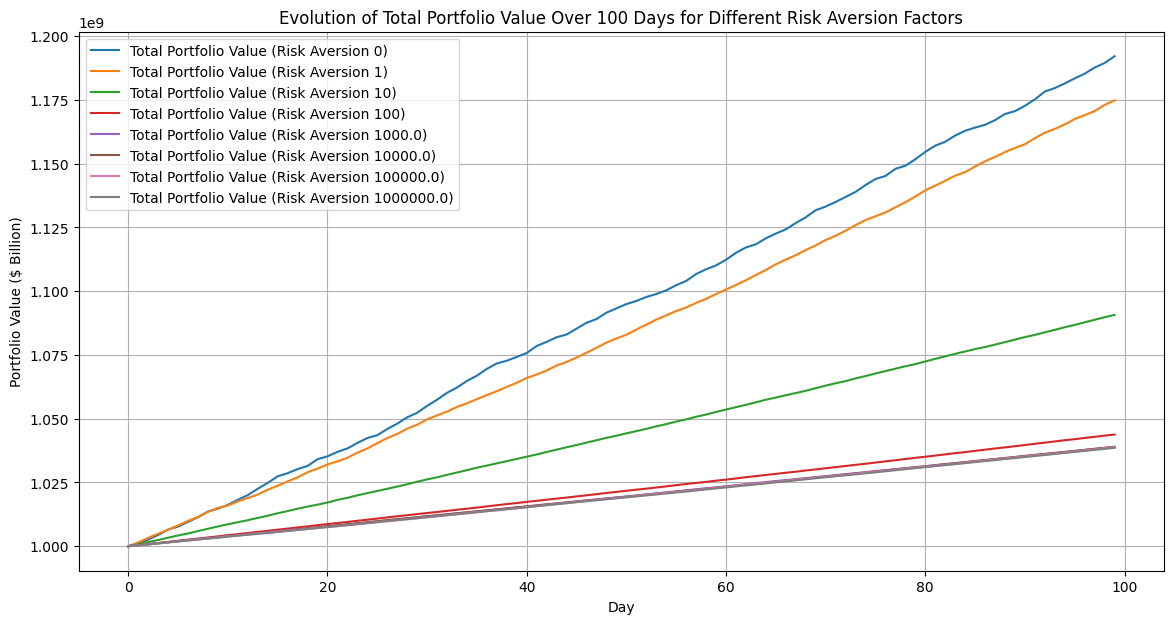

In [14]:
# l. After solving the portfolio optimization problem, simulate, and plot, 
# the evolution of the value of the porfolio as asset prices change over 100 consecutive days.  
# Assume an initial value of 1e9 (one billion). 

T = 100                                              # Day
initial_portfolio_value = 1e9                        # Initial portfolio value at day 0
risk_aversions = [0, 1, 10, 100, 1e3, 1e4, 1e5, 1e6] # List of risk aversion factors to iterate over
all_portfolio_values = []                            # Initialize a list to store portfolio values for each risk aversion factor

# l. Suppose that the average return for asset k is r(k), and its standard deviation is d(k). 
# Then, on each day t (between 0 and 99) we draw a uniform random variable r, 
# chosen from the interval [r(k) – d’(k), r(k) + d’(k)], where d’(k) = min( d(k), |r(k)/2|). 

# Calculate intervals
intervals = {}
for i in range(len(average_returns)):
    r_i = average_returns.iloc[i]
    d_i = standard_deviations.iloc[i]
    d_prime_i = min(d_i, abs(r_i / 2))
    interval = (r_i - d_prime_i, r_i + d_prime_i)
    intervals[i] = interval

for risk_aversion_focus in risk_aversions:
    # Access positions for the specific risk aversion
    if risk_aversion_focus in portfolio_positions:
        positions = portfolio_positions[risk_aversion_focus]
        print(f"Risk Aversion Factor: {risk_aversion_focus}")

        initial_values = {}
        r = {}     # Initialize the dictionary to store returns

        # Calculate and store the value of each asset at day 0
        for asset, position in positions.items():
            initial_values[asset] = position * initial_portfolio_value  # Store asset value in the dictionary

        asset_values_over_time = {i: [initial_values[i]] for i in initial_values}
        # Calculate the value changes over time for each asset
        for i in asset_values_over_time.keys():
            for t in range(1, T):                         # Start from day 1 to day T-1
        
                # l. a uniform random variable r, chosen from the interval [r(k) – d’(k), r(k) + d’(k)], 
                # where d’(k) = min( d(k), |r(k)/2|).
                low, high = intervals[i]                  # Get the interval for the current asset
                r[(i, t)] = np.random.uniform(low, high)  # Generate a random return
        
                # l. Then we scale the price of asset k on day t by multiplying it times 1 + r, 
                # to obtain the price of asset k on day t+1. We do this for each asset independently, 
                # for t = 0, then t=1, and so on, until reaching t = 99                        
                new_value = asset_values_over_time[i][t - 1] * (1 + r[(i, t)])  # Calculate new value for day t
                asset_values_over_time[i].append(new_value)                

        # Calculate the portfolio value for each day from day 0 to day 99
        portfolio_values_over_time = []
        for t in range(T):
            day_total_value = sum(asset_values_over_time[i][t] for i in asset_values_over_time)
            portfolio_values_over_time.append(day_total_value)

        # Store the portfolio values for the current risk aversion factor
        all_portfolio_values.append(portfolio_values_over_time)
        
    else:
        print(f"Risk Aversion Factor {risk_aversion_focus} not found in the portfolio positions.")

# l. As the price of all the assets evolve, so will the value of the porfolio. 
# Assume an initial value of 1e9 (one billion). Plot this evolution.

# Plotting all the total portfolio values on the same graph
plt.figure(figsize=(14, 7))
for i, risk_aversion_focus in enumerate(risk_aversions):
    plt.plot(all_portfolio_values[i], label=f'Total Portfolio Value (Risk Aversion {risk_aversion_focus})')
plt.title('Evolution of Total Portfolio Value Over 100 Days for Different Risk Aversion Factors')
plt.xlabel('Day')
plt.ylabel('Portfolio Value ($ Billion)')
plt.legend()
plt.grid(True)
plt.show()

The provided code snippet demonstrates a simulation of portfolio performance over a period of time for different levels of risk aversion. It integrates various components such as initial investment allocations based on risk preferences, asset return simulations over time, and portfolio value tracking. Here's a detailed breakdown of the key steps and functionalities within this code:

### Simulation Setup
- **Time Period (`T`)**: Represents the number of days (100 days) over which the simulation will run.
- **Initial Portfolio Value**: The starting value of the portfolio set at $1 billion.
- **Risk Aversions**: A list of risk aversion coefficients, indicating how risk-averse the investment strategy is. The higher the coefficient, the more the strategy focuses on minimizing risk compared to seeking returns.

### Intervals Calculation
- This block calculates intervals for each asset based on its average return and standard deviation. The interval represents possible return values for each asset on any given day. `d_prime_i` is calculated as the minimum of the standard deviation and half the absolute average return, adjusting the range to avoid excessively optimistic or pessimistic returns.
- **Intervals**: The interval for each asset is determined around its average return adjusted by `d_prime_i`, ensuring that the simulation of daily returns does not stray too far from expected behaviors.

### Simulation Loop
For each level of risk aversion:
1. **Accessing Positions**: Retrieves the specific portfolio positions for the given risk aversion factor, which were presumably optimized elsewhere in the code.
2. **Initial Asset Values**: Calculates the initial monetary value of each asset's position in the portfolio.
3. **Simulation Over Time**:
   - Initializes a dictionary to track the values of each asset over time.
   - For each day, simulates a return for each asset within the pre-calculated interval, updating the asset's value based on this simulated return.
   - Aggregates these values to determine the total portfolio value at the end of each day.

### Portfolio Value Calculation
- Aggregates values across all assets for each day to get the daily portfolio value, tracking how the total portfolio value evolves from day to day across the simulation period.

### Plotting
- Visualizes the evolution of portfolio value over 100 days for each level of risk aversion on the same graph. This helps in comparing how different risk approaches impact portfolio performance over time.

### Key Functions and Methods Used
- **`np.random.uniform(low, high)`**: Generates a random return within the specified interval for an asset, mimicking real-world fluctuations in asset prices.
- **Plotting with `matplotlib.pyplot`**: Provides a visual representation of the simulation results, showing the growth or decline of the portfolio over time under different risk conditions.

### Purpose and Utility
The simulation is particularly useful for illustrating the impact of risk aversion on portfolio management strategies. It provides insights into potential outcomes and helps in understanding how conservative or aggressive investment strategies might perform in varying market conditions over time.

This code is a comprehensive tool for risk analysis in financial portfolios, combining theoretical asset management strategies with practical, simulated outcomes.